In [1]:
import arviz as az
import numpy as np
"""
# If pymc3
"""
# import pymc3 as pm
# from theano import tensor as tt
"""
# If pymc4
"""
import pymc as pm
import aesara.tensor as tt

import random
import pickle
import os
import sys
import matplotlib.pyplot as plt

sys.path.append('../')

from data.data_loader import read_training_data
from config import Config
from os import path
from pickle import UnpicklingError

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1116)

In [2]:
def formalize_array(x, step, slice_len, skip, sliding_window=True):
    if sliding_window:
        N = int(np.floor((x.shape[0]-slice_len*step+1)/skip))
        x_all = np.zeros((N,slice_len))
        for i in range(N):
            x_all[i,:] = x[i*skip:i*skip+slice_len*step:step]
    else:
        x = x[0: -1: step]
        N = int(np.floor(x.shape[0]/slice_len))
        x_all = np.zeros((N,slice_len))
        for i in range(N):
            x_all[i,:] = x[slice_len*i:slice_len*(i+1)]
    return x_all

def load_training_data(base_path, step, min_traj_lenth, skip, pair_id_list, N):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=min_traj_lenth)
    slice_len=int(3/(step*Config.dt))
    for pair_id in pair_id_list:
        if pair_id == pair_id_list[0]:
            vt = formalize_array(tracks[pair_id]['vFollReal'], step, slice_len, skip)
            s = formalize_array(tracks[pair_id]['sReal'], step, slice_len, skip)
            dv = formalize_array(tracks[pair_id]['dvReal'], step, slice_len, skip)
            label_v = formalize_array(tracks[pair_id]['vFollReal_next'], step, slice_len, skip)
            id_idx = N*np.ones_like(label_v, dtype=int)
        else:
            vt = np.vstack((vt,formalize_array(tracks[pair_id]['vFollReal'], step, slice_len, skip)))
            s = np.vstack((s,formalize_array(tracks[pair_id]['sReal'], step, slice_len, skip)))
            dv = np.vstack((dv, formalize_array(tracks[pair_id]['dvReal'], step, slice_len, skip)))
            label_v = np.vstack((label_v, formalize_array(tracks[pair_id]['vFollReal_next'], step, slice_len, skip)))
            id_idx = np.vstack((id_idx, N*np.ones_like(formalize_array(tracks[pair_id]['sReal'], step, slice_len, skip), dtype=int)))
        N += 1
    print("Traj length:",min_traj_lenth*Config.dt, ", ID list:", pair_id_list, ", Data size:", label_v.shape)
    return vt, s, dv, label_v, id_idx

def GP_IDM_hierarchical(base_path, step):
    # load interactive data for car
    vt, s, dv, label_v, id_idx = load_training_data(base_path, step, min_traj_lenth=50/Config.dt,
                                           skip=20, pair_id_list=Config.car_interactive_pair_list[0:8], N=0)
    # load interactive data for truck
    vt2, s2, dv2, label_v2, id_idx2 = load_training_data(base_path, step, min_traj_lenth=50/Config.dt,
                                               skip=20, pair_id_list=Config.truck_interactive_pair_list[0:8],
                                                         N=len(Config.car_interactive_pair_list[0:8]))
    
    vt = np.vstack((vt,vt2))
    s = np.vstack((s, s2))
    dv = np.vstack((dv, dv2))
    label_v = np.vstack((label_v,label_v2))
    id_idx = np.vstack((id_idx,id_idx2))
    
    print("training size:", label_v.shape)
    ################################################
 
    dt = Config.dt
 
    D = 5
    
    N_veh = len(Config.car_interactive_pair_list[0:8])+len(Config.truck_interactive_pair_list[0:8])
    coords = {
    "veh_id": np.arange(N_veh),
    "obs_id": np.arange(label_v.shape[0]),
    "time_stamp": np.arange(label_v.shape[1]),
    }
   
    slice_len=int(3/(step*Config.dt))
    GP_t = np.array(range(slice_len*step))[0:-1:step].reshape(-1,1)
    shh = GP_t.shape[0]
  
    with pm.Model(coords=coords) as hierarchical_model:
        def IDM_v(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
            sn = DSAFE + vt * TSAFE + vt * dv / (2 * tt.sqrt(AMAX * AMIN))
            a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
            return vt + a * Config.dt
 
        id_idx = pm.ConstantData("id_idx", id_idx, dims=("obs_id","time_stamp"))
        s_ = pm.ConstantData("s", s, dims=("obs_id","time_stamp"))
        vt_ = pm.ConstantData("vt", vt, dims=("obs_id","time_stamp"))
        dv_ = pm.ConstantData("dv", dv, dims=("obs_id","time_stamp"))
        
        
        # Hyperpriors for group nodes
        chol, _, _ = pm.LKJCholeskyCov('chol', n=D, eta=2.0, sd_dist=pm.Exponential.dist(100.0, shape=D))
        cov = pm.Deterministic('cov', chol.dot(chol.T))
        
        vals_raw = pm.Normal('vals_raw',mu=0, sigma=1, shape=(N_veh, D), dims=('veh_id', ...))
        
        DELTA = 4
        log_mu_prior = pm.floatX(np.array([2., 0.69, 0.47, -.3, .51])) #[2., 1.6, .73, 1.67]
        
        log_mu = pm.MvNormal('log_mu', log_mu_prior, chol=chol)
        mu = pm.Deterministic('mu', tt.exp(log_mu))
        
        log_parameters = pm.Deterministic('log_mu_d', log_mu+tt.dot(chol,vals_raw.T).T)
        parameters = pm.Deterministic('mu_d', tt.exp(log_parameters))
        
        print("parameters.shape.eval():", parameters.shape.eval())
       
        #################################################
        # priors on the covariance function hyperparameters
        l = pm.Normal('l', mu=35, sigma=10)
 
        # Normal prior on the function variance
        s2_f = pm.Normal('s2_f', mu=0.01, sigma=0.001)
        #################################################
       
        log_s2_v = pm.Uniform('log_s2_v', lower=-8.0, upper=-4.0)
        s2_v = pm.Deterministic('s2_v', tt.exp(log_s2_v))
        
        cov_func = pm.gp.cov.ExpQuad(1, l)
        cov_obs = dt**2 * (s2_f* cov_func(GP_t)+s2_v*tt.eye(shh))
        
        v_obs = pm.MvNormal('obs',
                            mu=IDM_v(parameters[id_idx,0], parameters[id_idx,1], parameters[id_idx,2],
                                     parameters[id_idx,3], parameters[id_idx,4], DELTA, s_, vt_, dv_), cov=cov_obs,
                            observed=label_v, size=label_v.shape[0], dims=("obs_id","time_stamp"))
        tr = pm.sample(20000, tune=30000, random_seed=37, init='jitter+adapt_diag_grad', chains=1, cores=8,
                       discard_tuned_samples=True, return_inferencedata=True, target_accept=0.9)
       
    return tr, hierarchical_model

In [ ]:
base_path = '../data/highD/'
step = 3
tr, model = GP_IDM_hierarchical(base_path, step)

In [5]:
base_path = '../data/highD/'
cache = "../PGM/cache/GP_IDM_hierarchical-exp.pkl"

if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tr2 = pickle.load(fp)
        fp.close()
        print("Load trace", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)
else:
    output_file = open(cache, 'wb')
    pickle.dump(tr, output_file)
    output_file.close()
    print("Generated and Saved", output_file, ": done!")

Generated and Saved <_io.BufferedWriter name='../PGM/cache/GP_IDM_hierarchical-exp.pkl'> : done!


In [6]:
print(np.sqrt(tr.posterior.s2_v.mean(axis=0).mean(axis=0)))
print(np.sqrt(tr.posterior.s2_f.mean(axis=0).mean(axis=0)))

<xarray.DataArray 's2_v' ()>
array(0.10323947)
<xarray.DataArray 's2_f' ()>
array(0.21163963)


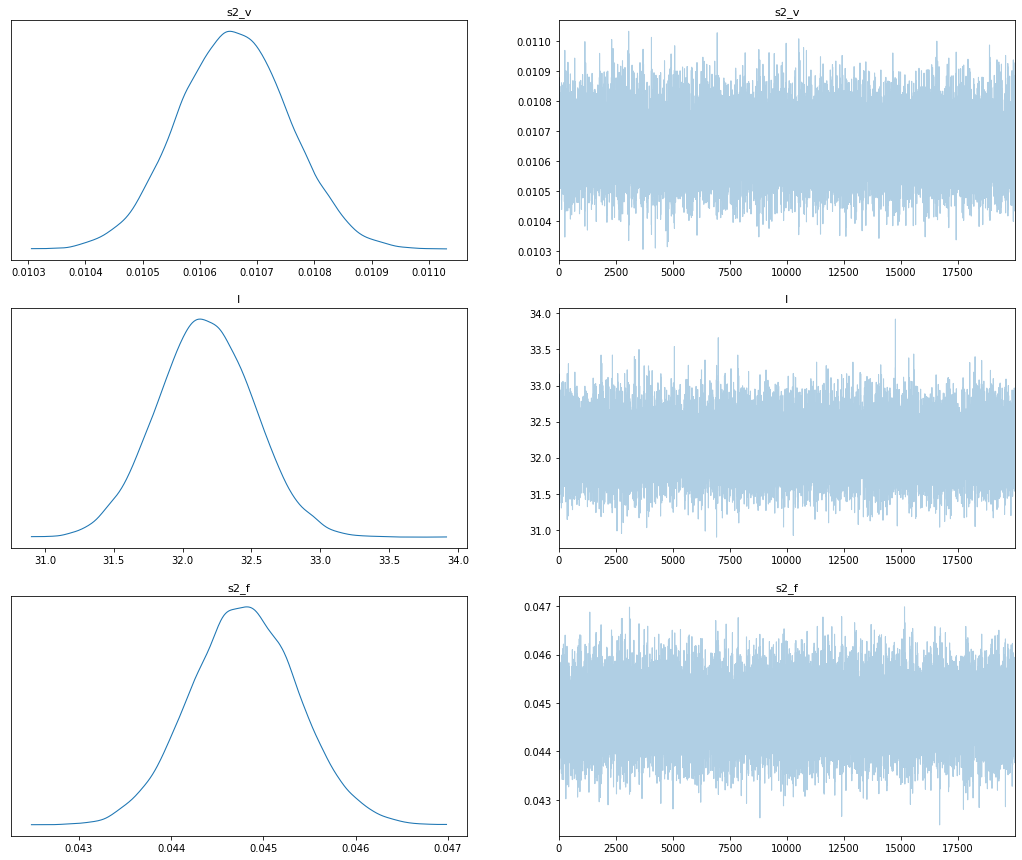

In [7]:
import arviz as az

_ = az.plot_trace(tr, var_names=["s2_v","l","s2_f"], figsize=((18, 15)))

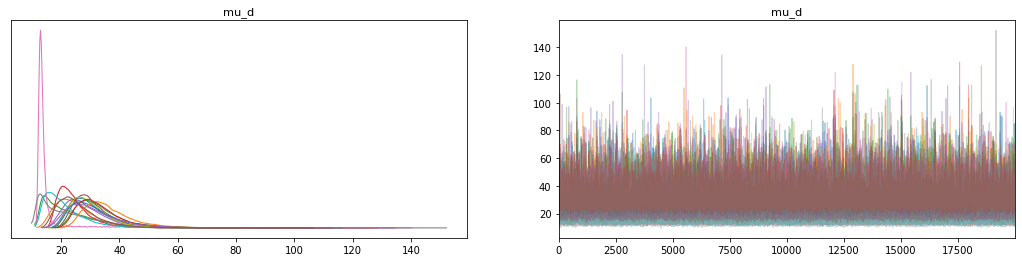

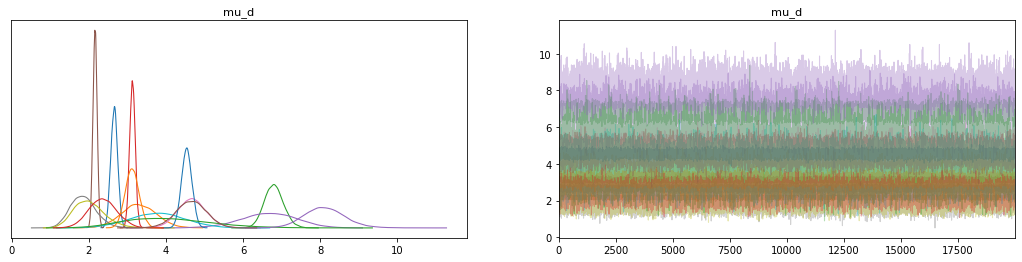

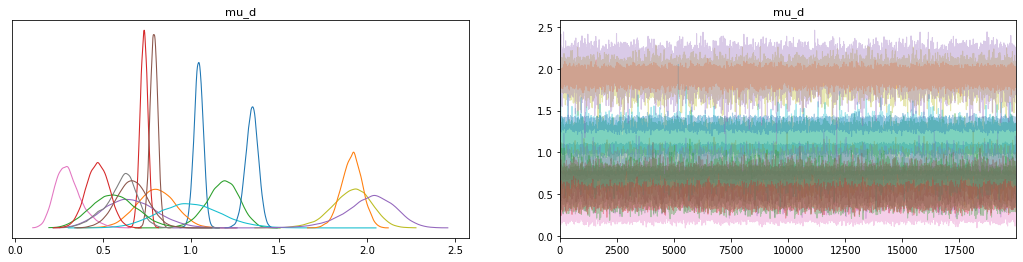

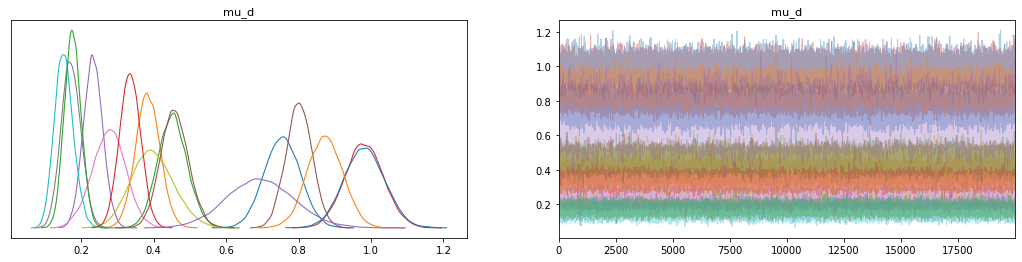

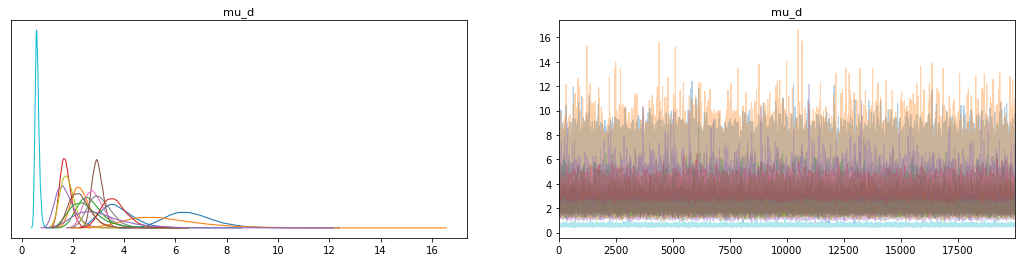

In [8]:
import arviz as az

_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":0}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":1}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":2}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":3}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu_d"], coords={"mu_d_dim_1":4}, figsize=((18, 4)),compact=True)

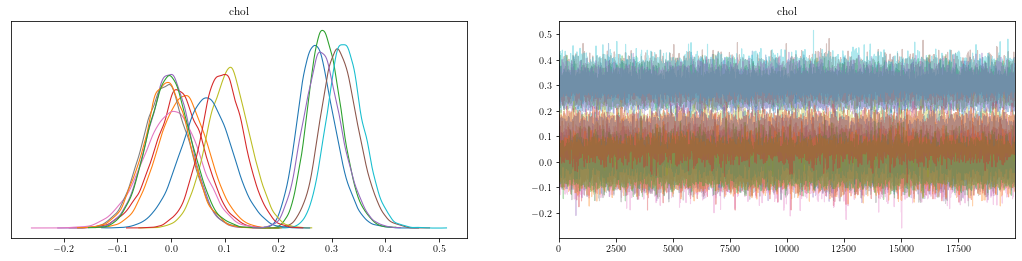

In [17]:
_ = az.plot_trace(tr, var_names=["chol"], figsize=((18, 4)),compact=True)

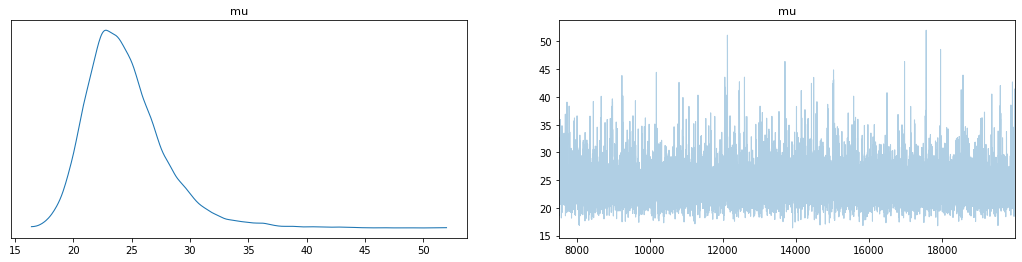

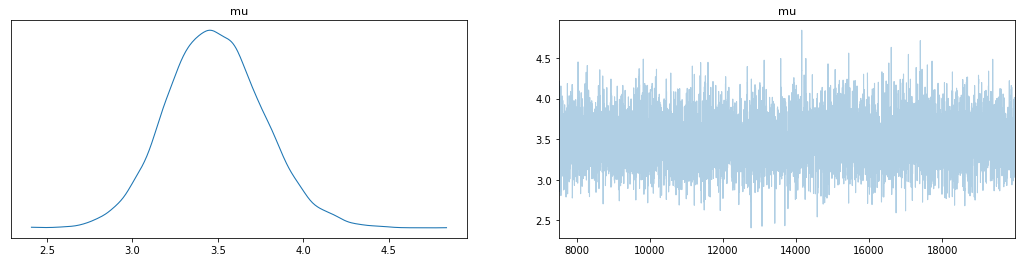

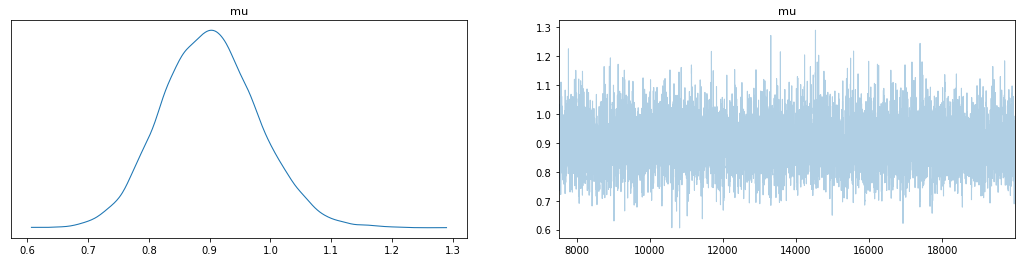

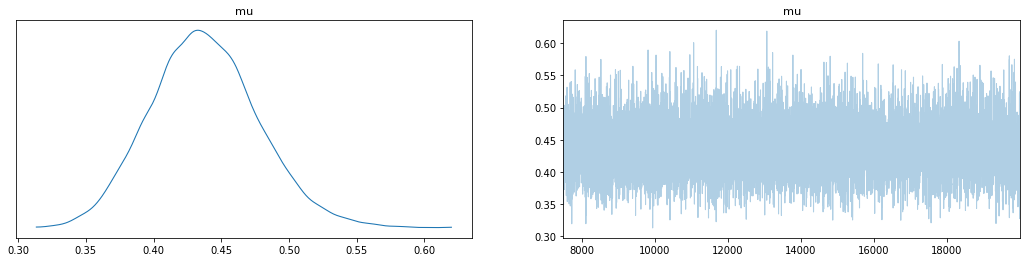

In [9]:
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":0,'draw':range(7500,20000)}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":1,'draw':range(7500,20000)}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":2,'draw':range(7500,20000)}, figsize=((18, 4)),compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":3,'draw':range(7500,20000)}, figsize=((18, 4)),compact=True)

In [20]:
az.summary(tr, var_names=["mu"]) # index 0-5 are: VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA
# six IDM parameters for the population driver

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],24.412,3.381,18.887,30.688,0.043,0.032,7982.0,7556.0,NaN
mu[1],3.484,0.280,2.966,4.014,0.003,0.002,6490.0,8835.0,NaN
mu[2],0.901,0.080,0.752,1.052,0.001,0.001,6254.0,9282.0,NaN
mu[3],0.438,0.040,0.361,0.511,0.000,0.000,12415.0,12800.0,NaN
mu[4],2.504,0.237,2.080,2.956,0.002,0.001,20939.0,15733.0,NaN


In [12]:
az.summary(tr, var_names=["mu_d"]) # index 0-5 are: VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA
# six IDM parameters for each driver

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"mu_d[0, 0]",29.819,7.317,18.459,43.154,0.051,0.038,24704.0,16193.0,NaN
"mu_d[0, 1]",2.659,0.089,2.493,2.824,0.001,0.000,21455.0,17772.0,NaN
"mu_d[0, 2]",1.042,0.026,0.996,1.093,0.000,0.000,21967.0,19084.0,NaN
"mu_d[0, 3]",0.755,0.049,0.664,0.848,0.000,0.000,22364.0,18290.0,NaN
"mu_d[0, 4]",3.717,0.658,2.554,4.946,0.004,0.003,24827.0,15730.0,NaN
...,...,...,...,...,...,...,...,...,...
"mu_d[15, 0]",25.892,7.447,14.761,38.911,0.074,0.053,13104.0,12336.0,NaN
"mu_d[15, 1]",4.646,0.397,3.899,5.392,0.002,0.002,27529.0,15895.0,NaN
"mu_d[15, 2]",0.664,0.090,0.497,0.836,0.001,0.000,26962.0,15097.0,NaN
"mu_d[15, 3]",0.458,0.039,0.389,0.534,0.000,0.000,21463.0,17663.0,NaN


In [13]:
az.summary(tr, var_names=["s2_v","l","s2_f"])

arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
s2_v,0.011,0.000,0.010,0.011,0.000,0.000,23432.0,14064.0,NaN
l,32.167,0.350,31.495,32.814,0.002,0.002,23538.0,15418.0,NaN
s2_f,0.045,0.001,0.044,0.046,0.000,0.000,23511.0,15137.0,NaN


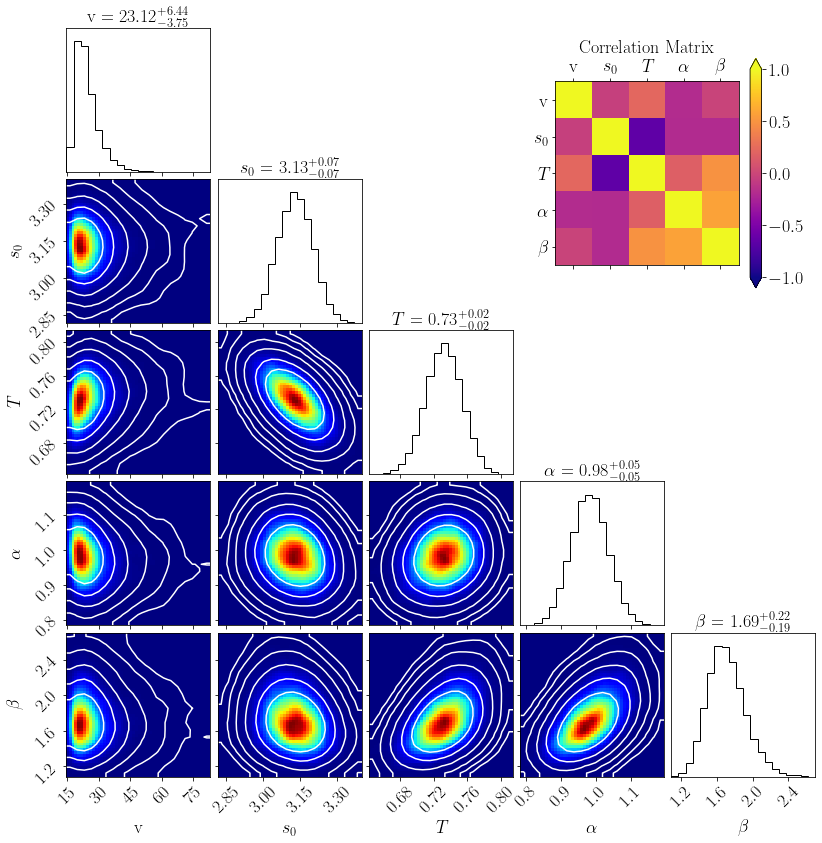

In [22]:
import corner

driver_id = 3

label_list = ['v',r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18

figure_d = corner.corner(
    tr,
    var_names=["mu_d"], coords={"mu_d_dim_0":driver_id},
    smooth=1.2,
    color = 'k',
    plot_contours=True,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure_d.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu_d[0,:,driver_id,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure_d.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

figure_d.savefig('../Figs/GP_IDM_hierarchical_driver2.pdf', dpi=300)

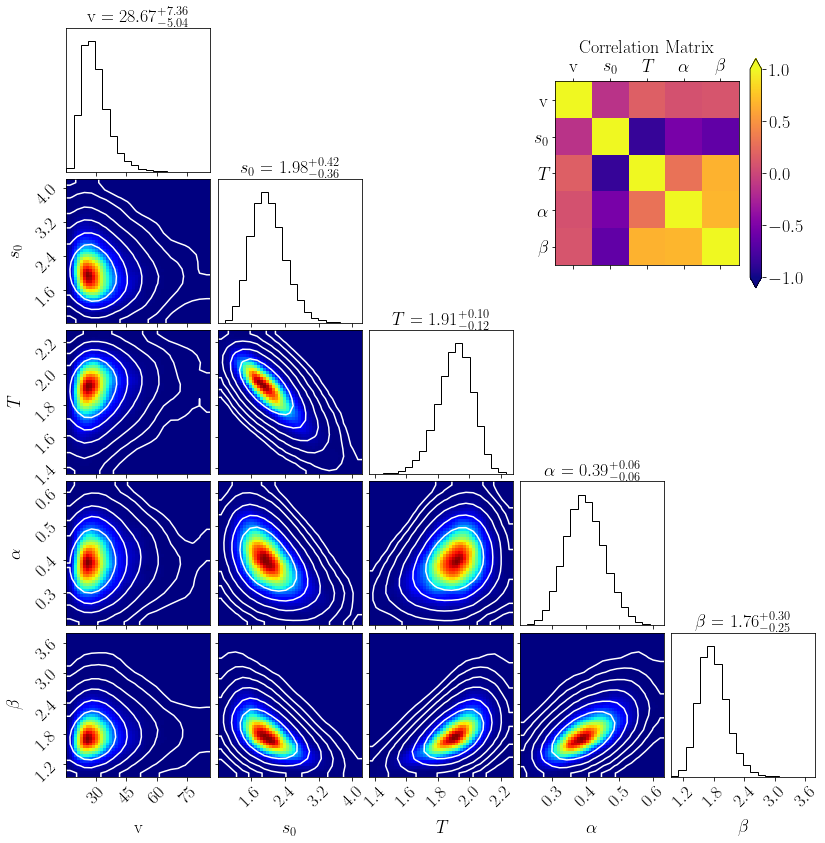

In [23]:
import corner

driver_id = 8

label_list = ['v', r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18

figure_d = corner.corner(
    tr,
    var_names=["mu_d"], coords={"mu_d_dim_0":driver_id},
    smooth=1.2,
    color = 'k',
    plot_contours=True,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure_d.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu_d[0,:,driver_id,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure_d.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

figure_d.savefig('../Figs/GP_IDM_hierarchical_driver8.pdf', dpi=300)

In [ ]:
az.waic(tr)